In [8]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from itertools import chain, combinations
import grakel
from grakel import GraphKernel



def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

In [9]:
g = nx.cycle_graph(5)
g.add_edge(2, 0)

edges_missing = np.array(list(nx.non_edges(g)))
to_adds = list(powerset(range(len(edges_missing))))
other_graphs = []
for to_add in to_adds:
    if to_add == ():
        new_g = g.copy()
        other_graphs.append(new_g)
    else:
        new_g = g.copy()
        new_g.add_edges_from(edges_missing[np.array(to_add)])

        is_isomorphic=False
        for other_g in other_graphs:
            if nx.is_isomorphic(new_g, other_g):
                is_isomorphic = True
        if not is_isomorphic:
            other_graphs.append(new_g)
        

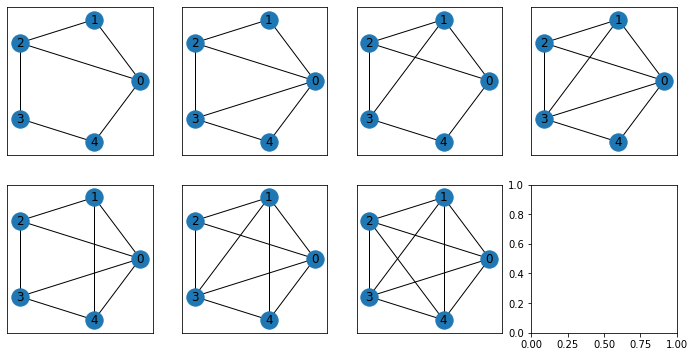

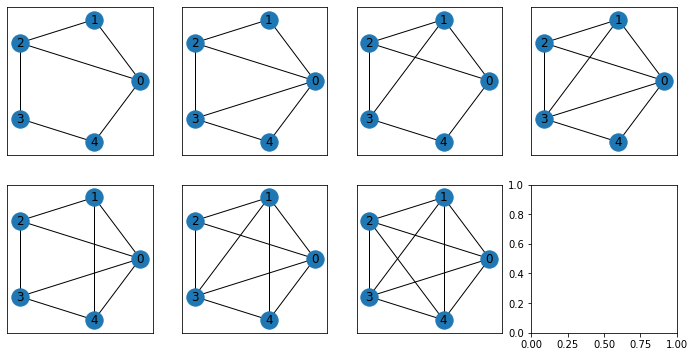

In [10]:
fig, ax = plt.subplots(2, 4, figsize=(12, 6))
pos = nx.circular_layout(g)
for i in range(7):
    nx.draw_networkx(other_graphs[i], ax=ax.flatten()[i], pos=pos)
fig

In [11]:
import networkx as nx
import numpy as np
import grakel
from sklearn.model_selection import train_test_split

def make_er_motif(n, motif):
    while True:
        g = nx.erdos_renyi_graph(n, np.log(n)/n)
        connected = nx.is_connected(g)
        if connected and g.has_edge(0, 1):
            break
    g = nx.relabel_nodes(g, {i: i+3 for i in range(n)})
    g.add_edges_from(motif.edges())
    nx.set_node_attributes(g, {i: 1 for i in g.nodes()}, 'node_label')
    nx.set_edge_attributes(g, {i: 1 for i in g.edges()}, 'edge_label')
    return g

# specify the two motifs
motif1 = nx.cycle_graph(5)
motif2 = nx.complete_graph(5)

# generate the dataset
dataset = []
labels = []
for _ in range(50):
    dataset.append(make_er_motif(15, motif1))
    dataset.append(make_er_motif(15, motif2))
    labels.append(0)
    labels.append(1)
labels = np.array(labels)
dataset = list(grakel.graph_from_networkx(dataset, node_labels_tag='node_label', edge_labels_tag='edge_label'))
G_train, G_test, y_train, y_test = train_test_split(dataset, labels, train_size=50, random_state=42)



In [12]:
from grakel.kernels import GraphletSampling, NeighborhoodSubgraphPairwiseDistance
from sklearn.svm import SVC
import numpy as np
import pickle
import os


# fit the kernel
kernel = NeighborhoodSubgraphPairwiseDistance()
K_train = kernel.fit_transform(G_train)
clf = SVC(kernel='precomputed')
clf.fit(K_train, y_train)

# evaluate on the test set
K_test = kernel.transform(G_test)
y_pred = clf.predict(K_test)
test_accuracy = np.mean(y_pred == y_test)
print(f'Test set accuracy {test_accuracy}')


Test set accuracy 1.0


In [13]:
%%timeit
K_test = kernel.transform(G_test)
y_pred = clf.predict(K_test)

889 ms ± 4.12 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
# WL kernel 

# fit the kernel
wl_kernel = GraphletSampling()
K_train = wl_kernel.fit_transform(G_train)
wl_clf = SVC(kernel='precomputed')
wl_clf.fit(K_train, y_train)

# evaluate on the test set
K_test = wl_kernel.transform(G_test)
y_pred = wl_clf.predict(K_test)
test_accuracy = np.mean(y_pred == y_test)
print(f'Test set accuracy {test_accuracy}')

Test set accuracy 0.9


In [15]:
%%timeit
K_test = wl_kernel.transform(G_test)
y_pred = wl_clf.predict(K_test)

3.21 s ± 59.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [24]:
# fit the kernel
from grakel.kernels import WeisfeilerLehman, ShortestPath

kernel = WeisfeilerLehman(base_graph_kernel=ShortestPath)
K_train = kernel.fit_transform(G_train)
clf = SVC(kernel='precomputed')
clf.fit(K_train, y_train)

# evaluate on the test set
K_test = kernel.transform(G_test)
y_pred = clf.predict(K_test)
test_accuracy = np.mean(y_pred == y_test)
print(f'Test set accuracy {test_accuracy}')

Test set accuracy 0.92


In [25]:
%%timeit
K_test = kernel.transform(G_test)
y_pred = clf.predict(K_test)

644 ms ± 47.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [25]:
for i, graph in enumerate(other_graphs):
    test_dataset = []
    for _ in range(100):
        test_dataset.append(make_er_motif(15, graph))
    test_dataset = list(grakel.graph_from_networkx(test_dataset))
    K_test = wl_kernel.transform(test_dataset)
    y_pred = clf.predict(K_test)
    print(i, np.mean(y_pred))

0 0.02
1 0.01
2 0.02
3 0.15
4 0.03
5 0.44
6 0.98


In [8]:
for i, graph in enumerate(other_graphs):
    test_dataset = []
    for _ in range(100):
        test_dataset.append(make_er_motif(15, graph))
    test_dataset = list(grakel.graph_from_networkx(test_dataset))
    K_test = wl_kernel.transform(test_dataset)
    y_pred = clf.predict(K_test)
    print(i, np.mean(y_pred))

NameError: name 'wl_kernel' is not defined